In [141]:
import cebra
from cebra import CEBRA

In [142]:
import csv
from edgeDetection import *
import os
import matplotlib
# matplotlib.use('PS')
import matplotlib.pyplot as plt
import numpy as np
from readTabTxtFile import *
from calTempResolution import *
from trimmedTriggerTime import *
import seaborn as sn
import scipy
import pickle


In [143]:
from sklearn.model_selection import train_test_split
import tempfile
from pathlib import Path
import gc

gc.collect()
import torch

torch.cuda.empty_cache()

In [144]:
directory = "/media/watson/UbuntuHDD/feng_Xin/Xin/Miniscope/5133307132023/reward_seeking/days_with_miniscope_recording/day26/15_18_15"



# for 51331, 51332 and 51333
frameInput = 3
lickTrigNum = 2
pokeTrigNum = 0
caTimeNum = 3
pumpTrigNum = 1

validIdFile = "validIdx.txt"
cellTracesFile = "cellTraces_norm.txt"
pokeTriggerFile = "stim"+str(pokeTrigNum)+".txt"
lickTriggerFile = "stim"+str(lickTrigNum)+".txt"
pumpTriggerFile = "stim"+str(pumpTrigNum)+".txt"

caTimeFile = "stim"+str(caTimeNum)+".txt"
plotSavingFolder = 'Plots'
videoFrameNum = 1000

with open(directory + os.sep + 'frame_correction_pos.pickle','rb') as f:
    frame_correction = pickle.load(f)

def findClosestTimeIndex(t,tSeries):
    tDiff = [abs(t-i) for i in tSeries]
    nd_tDiff = np.array(tDiff)
    pos = np.argmin(nd_tDiff)
    return pos
def findClosestLickIndex(t1Series,refT,tSeries):
    tDiff = [[i-refT,i] for i in t1Series if i-refT>=0]
    nd_tDiff = np.array(tDiff)
    lick_pos = np.argmin(nd_tDiff[:,0])
    pos = findClosestTimeIndex(nd_tDiff[lick_pos,1],tSeries)
    return pos

def findAfterClosestIndex(t1Series,refT,tSeries):
    tDiff = [[i-refT,i] for i in t1Series if i-refT>=0]
    nd_tDiff = np.array(tDiff)
    lick_pos = np.argmin(nd_tDiff[:,0])
    pos = findClosestTimeIndex(nd_tDiff[lick_pos,1],tSeries)
    return pos

def findBeforeClosestIndex(t1Series,refT,tSeries):
    tDiff = [[i-refT,i] for i in t1Series if i-refT<=0]
    nd_tDiff = np.array(tDiff)
    lick_pos = np.argmax(nd_tDiff[:,0])
    pos = findClosestTimeIndex(nd_tDiff[lick_pos,1],tSeries)
    return pos

def findAllLickIndices(t1Series,refT,tSeries,window):
    pos=[]
    tDiff = [[i - tSeries[refT], i] for i in t1Series if i-tSeries[refT]>0 and i-tSeries[refT]-window*caFrameDur<0]
    nd_tDiff = np.array(tDiff)
    for i in nd_tDiff:
        pos_temp = findClosestTimeIndex(i[1],tSeries)
        pos.append(pos_temp)
    return pos

def interpolateNaN(x):
    loc = np.argwhere(np.isnan(x))
    for i in loc:
        x[i[0]] = (x[i[0]-1] + x[i[0]+1])/2
    return x
with open(directory+os.sep+cellTracesFile, "r", newline="\n") as readFile:
    data_reader = readFile.readlines()
# with open(directory+os.sep+validIdFile, "r", newline="") as readFile:
#     id_reader = readFile.readlines()
# with open(directory+os.sep+triggerFile, "r", newline="") as readFile:
#     trig_reader = readFile.readlines()
# with open(directory+os.sep+caTimeFile, "r", newline="") as readFile:
#     caTime_reader = readFile.readlines()

caData = readTabTxtFile(directory+os.sep+cellTracesFile, 'float')
valid_idx = readTabTxtFile(directory+os.sep+validIdFile, 'int')
pokeTrigTime = readTabTxtFile(directory+os.sep+pokeTriggerFile, 'float')
lickTrigTime = readTabTxtFile(directory+os.sep+lickTriggerFile, 'float')
caTime = readTabTxtFile(directory+os.sep+caTimeFile, 'float')
caFrameDur = calTempResolution(caTime)
pumpTrigTime = readTabTxtFile(directory+os.sep+pumpTriggerFile, 'float')

# valid_idx = [int(i) for i in id_reader[0].strip().split("\t")]
# caTime = [float(i) for i in caTime_reader[0].strip().split("\t")]
# trigTime = [float(i) for i in trig_reader[0].strip().split("\t")]
numVideoShift = 0
preTrigWindow_poke = -15
postTrigWindow_poke = 15
preTrigWindow_lick = -15
postTrigWindow_lick = 15
len_window = postTrigWindow_poke-preTrigWindow_poke
trimmed_pokeTrigTime = trimmedTriggerTime(pokeTrigTime,caTime,videoFrameNum*numVideoShift,-1)
trimmed_lickTrigTime = trimmedTriggerTime(lickTrigTime,caTime,videoFrameNum*numVideoShift,-1)
trimmed_pumpTrigTime = trimmedTriggerTime(pumpTrigTime,caTime,videoFrameNum*numVideoShift,-1)

# numTrig = len(trimmed_pokeTrigTime)
numTrig_pump = len(trimmed_pumpTrigTime)
numTrig_poke = len(trimmed_pokeTrigTime)
numTrig_lick = len(trimmed_lickTrigTime)

numData = len(caData)
numAnalysisWindow = -1*preTrigWindow_poke+postTrigWindow_poke
pokeTimeAdj = 0.03

# zscore_ca_good = np.zeros((len(valid_idx),numTrig_pump,len_window))
# zscore_ca_poke = np.zeros((len(valid_idx),1,len_window))
# zscore_ca_lick = np.zeros((len(valid_idx),1,len_window))

# zscore_ca_good = np.array([])
# zscore_ca_poke = np.array([])
# zscore_ca_lick = np.array([])
# zscore_ca_noTrig = np.array([])

In [145]:

def findClosestTimeIndex(t,tSeries):
    tDiff = [abs(t-i) for i in tSeries]
    nd_tDiff = np.array(tDiff)
    pos = np.argmin(nd_tDiff)
    return pos

trigger_variable = np.zeros((numData,1))

for i in np.arange(0,numTrig_poke,1):
    temp_pos = findClosestTimeIndex(trimmed_pokeTrigTime[i],caTime)
    trigger_variable[temp_pos,0]=1

for i in np.arange(0,numTrig_lick,1):
    temp_pos = findClosestTimeIndex(trimmed_lickTrigTime[i],caTime)
    trigger_variable[temp_pos,0]=2


In [146]:
zscore_ca_trace = np.array([])
for i in range(len(valid_idx)):
    ca_trace = [float(k) for k in data_reader[valid_idx[i]].strip().split("\t")]
    if frame_correction:
        ca_trace_corrected_temp = ca_trace[0:frame_correction[0]+1]+ [float('NaN')]*frame_correction[1] + ca_trace[frame_correction[0]+1:-1]
        ca_trace_corrected = interpolateNaN(ca_trace_corrected_temp)

    else:
        ca_trace_corrected = ca_trace
    if i == 0:
        zscore_ca_trace = scipy.stats.zscore(ca_trace_corrected)
        zscore_ca_trace = np.expand_dims(zscore_ca_trace,axis=0)
        print(zscore_ca_trace.shape)
    else:
        print(zscore_ca_trace.shape)
        zscore_ca_trace = np.append(zscore_ca_trace,np.expand_dims(scipy.stats.zscore(ca_trace_corrected),axis=0),axis=0)

zscore_ca_trace_T = np.transpose(zscore_ca_trace)

(1, 89355)
(1, 89355)
(2, 89355)
(3, 89355)
(4, 89355)
(5, 89355)
(6, 89355)
(7, 89355)
(8, 89355)
(9, 89355)
(10, 89355)
(11, 89355)
(12, 89355)
(13, 89355)
(14, 89355)
(15, 89355)
(16, 89355)
(17, 89355)
(18, 89355)
(19, 89355)
(20, 89355)
(21, 89355)
(22, 89355)
(23, 89355)
(24, 89355)
(25, 89355)
(26, 89355)
(27, 89355)
(28, 89355)
(29, 89355)
(30, 89355)


In [147]:
# params_grid = dict(
#     output_dimension = [3, 5],
#     learning_rate = [0.001],
#     time_offsets = [1,10,100],
#     max_iterations = 10000,
#     batch_size = 1024,


#     temperature = [0.01,0.1,1,10],
#     verbose = True)

# datasets = {"dataset1": zscore_ca_trace_T,                      # time contrastive learning
# }


# # 3. Create and fit the grid search to your data
# grid_search = cebra.grid_search.GridSearch()
# grid_search.fit_models(datasets=datasets, params=params_grid, models_dir="saved_models")

In [148]:
# # 4. Get the results
# df_results = grid_search.get_df_results(models_dir="saved_models")

# # 5. Get the best model for a given dataset
# best_model, best_model_name = grid_search.get_best_model(dataset_name="dataset1", models_dir="saved_models")

In [149]:
cebra_model = CEBRA(
    model_architecture = "offset10-model",
    temperature=0.01,
    learning_rate = 0.001,
    max_iterations = 10000,
    batch_size = 1024,
    max_adapt_iterations = 500,
    time_offsets = 10,
    output_dimension = 5,
    device = "cuda_if_available",
    verbose = True,
    conditional='time_delta',
    hybrid=True
)

# 2. Load example data
# neural_data = cebra.load_data(file="neural_data.npz", key="neural")
# new_neural_data = cebra.load_data(file="neural_data.npz", key="new_neural")
# continuous_label = cebra.load_data(file="auxiliary_behavior_data.h5", key="auxiliary_variables", columns=["continuous1", "continuous2", "continuous3"])
# discrete_label = cebra.load_data(file="auxiliary_behavior_data.h5", key="auxiliary_variables", columns=["discrete"]).flatten()

# assert neural_data.shape == (100, 3)
# assert new_neural_data.shape == (100, 4)
# assert discrete_label.shape == (100, )
# assert continuous_label.shape == (100, 3)

# 3. Split data and labels
(
    train_data,
    valid_data,
    train_discrete_label,
    valid_discrete_label,
) = train_test_split(zscore_ca_trace_T,
                     trigger_variable,
                    test_size=0.3)

# 4. Fit the model
# time contrastive learning
cebra_model.fit(train_data,train_discrete_label)

behavior_pos: -49.9312 behavior_neg:  49.9556 behavior_total:  0.0244 time_pos: -99.9949 time_neg:  106.9257 time_total:  6.9308: 100%|██████████| 10000/10000 [04:14<00:00, 39.27it/s]


CEBRA(batch_size=1024, conditional='time_delta', hybrid=True,
      learning_rate=0.001, model_architecture='offset10-model',
      output_dimension=5, temperature=0.01, time_offsets=10, verbose=True)

In [150]:

train_embedding = cebra_model.transform(train_data)
valid_embedding = cebra_model.transform(valid_data)

<Axes3DSubplot:title={'center':'Embedding'}>

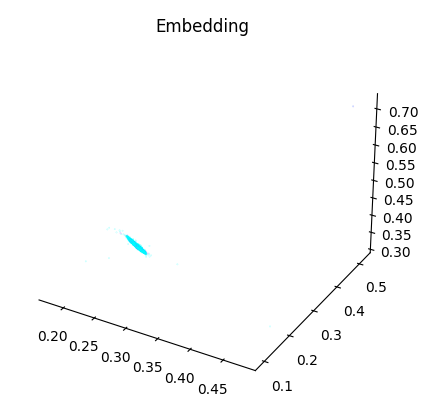

In [151]:
cebra.plot_embedding(train_embedding, embedding_labels=train_discrete_label[:,0])

<AxesSubplot:xlabel='Steps', ylabel='InfoNCE Loss'>

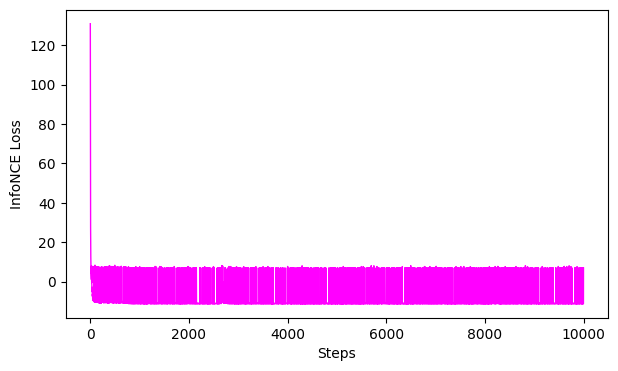

In [152]:
cebra.plot_loss(cebra_model)


In [ ]:
valid_discrete_label.shape

In [ ]:

goodness_of_fit = cebra.sklearn.metrics.infonce_loss(cebra_model,
                                                     valid_data,
                                                     valid_discrete_label,
                                                     num_batches=5)



In [153]:

decoder = cebra.KNNDecoder()
decoder.fit(train_embedding,train_continuous_label)
prediction = decoder.predict(valid_embedding)


In [154]:
score = decoder.score(valid_embedding, valid_continous_label)


In [155]:
score

-0.3487574086813644